In [35]:
import optuna
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [36]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [37]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
df=pd.read_csv('fashion-mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
df.shape

(60000, 785)

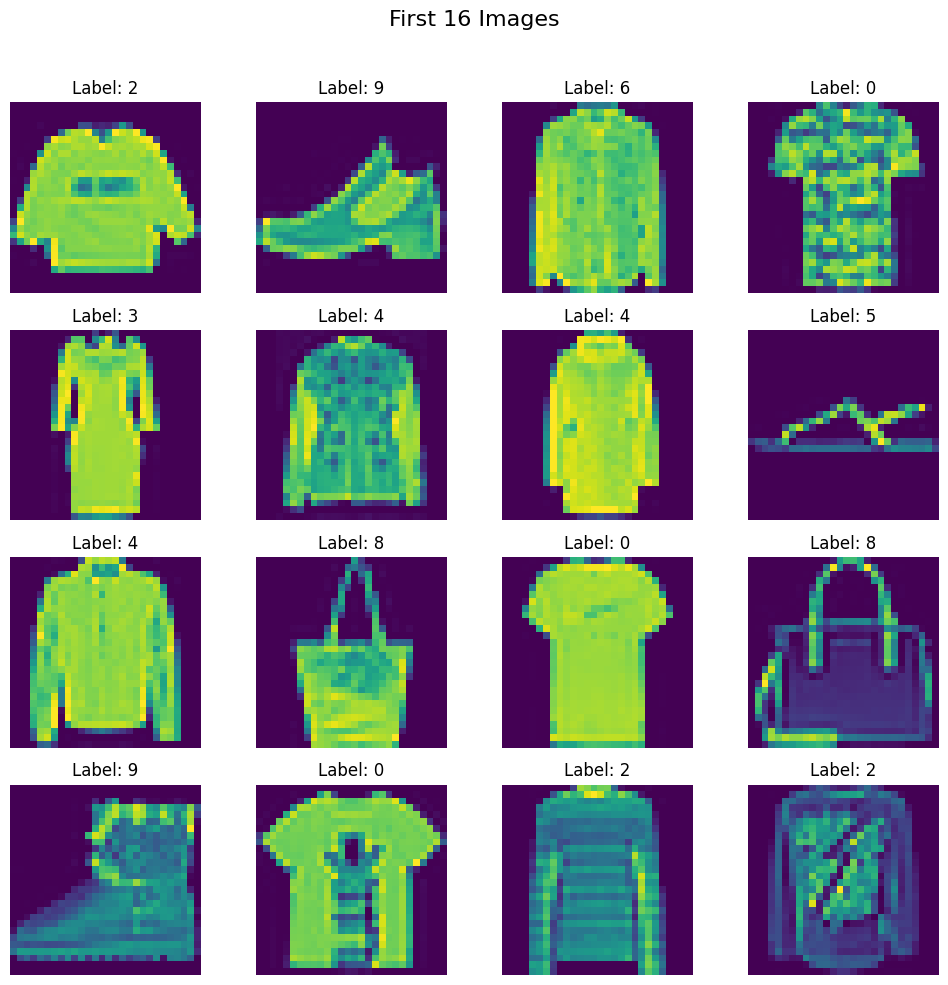

In [40]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img)  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

In [41]:
# train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [42]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [43]:
#transformations
from torchvision.transforms import transforms

custom_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [44]:
from PIL import Image
import numpy as np

class CustomDataset(Dataset):
    def __init__(self,features,labels,transform):   
        self.features=features
        self.labels=labels
        self.transform=transform

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        
        #resize to 28*28
        image=self.features[index].reshape(28,28)

        #change datatype to np.uint8
        image=np.array(image,dtype=np.uint8)

        #change black and white to rgb
        image=np.stack((image,image,image),axis=-1)

        #convert array to PIL image
        image=Image.fromarray(image)

        #apply transformations
        image=self.transform(image)

        return image,torch.tensor(self.labels[index],dtype=torch.long) #self.labels[index]

In [45]:
train_dataset=CustomDataset(X_train,y_train,custom_transform)
test_dataset=CustomDataset(X_test,y_test,custom_transform)

In [46]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False,pin_memory=True)

In [47]:
#fetch the pretrained model
import torchvision.models as models

vgg16=models.vgg16(pretrained=True)

c:\Users\ayush\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ayush\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [49]:
for param in vgg16.features.parameters():
    param.requires_grad=False
    

In [50]:
vgg16.classifier=nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024,512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,10)
)

In [51]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [52]:
vgg16=vgg16.to(device)

In [53]:
learning_rate=0.0001
epochs=50

criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(vgg16.classifier.parameters(),lr=learning_rate)

In [54]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = vgg16(batch_features)

    print(outputs.shape)
    print(batch_labels.shape)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

    break

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')


torch.Size([32, 10])
torch.Size([32])
Epoch: 1 , Loss: 0.0015550451278686524
torch.Size([32, 10])
torch.Size([32])
Epoch: 2 , Loss: 0.0015089624722798665
torch.Size([32, 10])
torch.Size([32])
Epoch: 3 , Loss: 0.0014578932126363118
torch.Size([32, 10])
torch.Size([32])
Epoch: 4 , Loss: 0.001431173006693522
torch.Size([32, 10])
torch.Size([32])
Epoch: 5 , Loss: 0.00141899840037028
torch.Size([32, 10])
torch.Size([32])
Epoch: 6 , Loss: 0.0013579626083374023
torch.Size([32, 10])
torch.Size([32])
Epoch: 7 , Loss: 0.0013598887125651042
torch.Size([32, 10])
torch.Size([32])
Epoch: 8 , Loss: 0.001236127773920695
torch.Size([32, 10])
torch.Size([32])
Epoch: 9 , Loss: 0.0012726530234018962
torch.Size([32, 10])
torch.Size([32])
Epoch: 10 , Loss: 0.0011148833433787027
torch.Size([32, 10])
torch.Size([32])
Epoch: 11 , Loss: 0.0012683622042338053
torch.Size([32, 10])
torch.Size([32])
Epoch: 12 , Loss: 0.0010715861320495605
torch.Size([32, 10])
torch.Size([32])
Epoch: 13 , Loss: 0.0010337007840474446

In [56]:
vgg16.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [57]:
# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = vgg16(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.8158333333333333
